In [1]:
# Trying multiples naive approach on fraud_detection.

# Sources:
# - https://www.data-blogger.com/2017/06/15/fraud-detection-a-simple-machine-learning-approach/
# - https://gist.github.com/abnvanand/0aba78f2ce94c5aa9d6a1473a0ed8df7
# - https://www.datasciencesmachinelearning.com/2018/11/confusion-matrix-accuracy-precision.html
# - https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data
# - https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/

FILES_DIR = "ieee-fraud-detection"
# DataSet: Unzip data in ieee-fraud-detection
# - https://www.kaggle.com/c/ieee-fraud-detection/data

import os
assert os.path.exists(FILES_DIR), f'missing folder {FILES_DIR}, download data from Kaggle'

import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 75)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# Load Dataframes

In [2]:
get_file = lambda fname: FILES_DIR + '/' + fname

def merge_csv_as_df(transaction, identity, on='TransactionID'):
    transaction = pd.read_csv(get_file(f'{transaction}.csv'))
    identity = pd.read_csv(get_file(f'{identity}.csv'))
    print("from", transaction.shape)
    print("and from", identity.shape)
    X = transaction.merge(identity, on=on, how='left')
    del transaction
    del identity
    print("to", X.shape)
    return X

X_train = merge_csv_as_df('train_transaction', 'train_identity')
y_train = X_train['isFraud']
print(X_train['isFraud'].unique())

from (590540, 394)
and from (144233, 41)
to (590540, 434)
[0 1]


# Select Features

In [3]:
# Remove columns 
infos = {}
for c in X_train.columns:
    infos[c] = len(X_train[c].unique()) / len(X_train[c]) * 100.
features = [ c for c, score in infos.items() if 1 <= score <= 85. ]
print(f"{len(features)} are selected.")

# Display dtype of features
from collections import defaultdict
dtypes = defaultdict(int)
for feature in features:
    dtypes[X_train[feature].dtype] += 1
print(dtypes)
    
# Reduce dataframe to selected features
X_train = X_train[features]
origin_X_train = X_train.copy()

36 are selected.
defaultdict(<class 'int'>, {dtype('float64'): 35, dtype('int64'): 1})


# Deal with NaN values

In [4]:
X_train.fillna(-999, inplace=True)

def normalize(X):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X

# Try 1: Logistic Regression

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284939
           1       0.21      0.00      0.01     10331

    accuracy                           0.96    295270
   macro avg       0.59      0.50      0.50    295270
weighted avg       0.94      0.96      0.95    295270



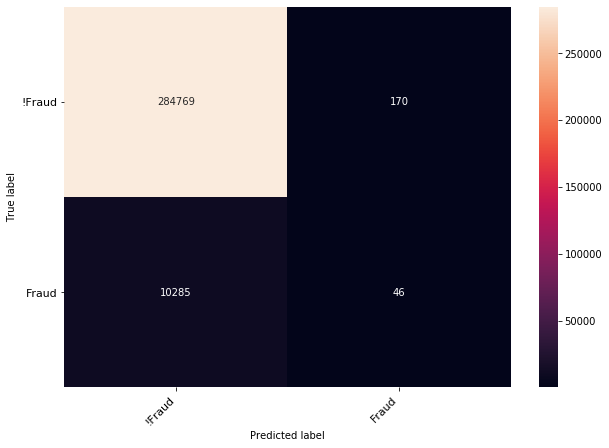

0.5019279997038588


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

X = X_train.copy()
y = y_train.copy()

# Define the model
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    _X_train, _y_train = X.iloc[train_indices], y.iloc[train_indices]
    _X_test, _y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Normalize the data
    _X_train = normalize(_X_train)
    _X_test = normalize(_X_test)
    
    # Fit and predict!
    model.fit(_X_train, _y_train)
    _y_pred = model.predict(_X_test)
    
    # And finally: show the results
    print(classification_report(_y_test, _y_pred))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(_y_test, _y_pred)
x = print_confusion_matrix(cm, class_names=['!Fraud', 'Fraud'])
plt.show()

from sklearn.metrics import roc_auc_score
print(roc_auc_score(_y_test, _y_pred))

# Try 2: Logistic Regression on PCA

In [6]:
from sklearn.decomposition import PCA

def do_pca(X, y_train, n_components=4):
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents,
                               columns = [f'pc_{i}' for i in range(n_components)])
    tp = pd.concat([principalDf, y_train], axis=1)
    return tp, pca

n_components = 5

finalDf, pca = do_pca(X_train.copy(), y.copy(), n_components=n_components)
print("#"*80)
print(f"{n_components} components explain {100.*pca.explained_variance_ratio_.sum():.2f}% of the information.")
print("#"*80)

################################################################################
5 components explain 99.91% of the information.
################################################################################


[0 1]
['!Fraud' 'Fraud']


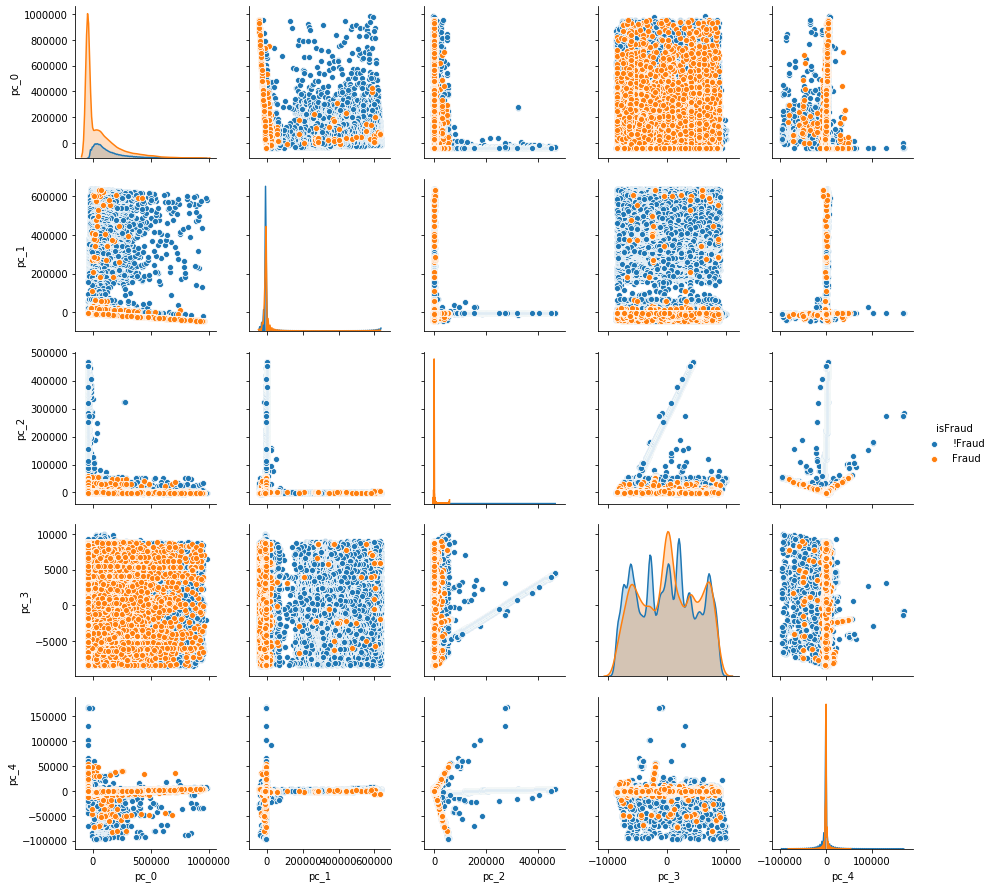

In [7]:
# Display PairPlot PCA
print(finalDf['isFraud'].unique())
is_fraud = {0.0:'!Fraud', 1.0:'Fraud'}
finalDf['isFraud'] = finalDf['isFraud'].map(is_fraud)
print(finalDf['isFraud'].unique())
sns.pairplot(finalDf, hue='isFraud')

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284939
           1       0.21      0.00      0.01     10331

    accuracy                           0.96    295270
   macro avg       0.59      0.50      0.50    295270
weighted avg       0.94      0.96      0.95    295270



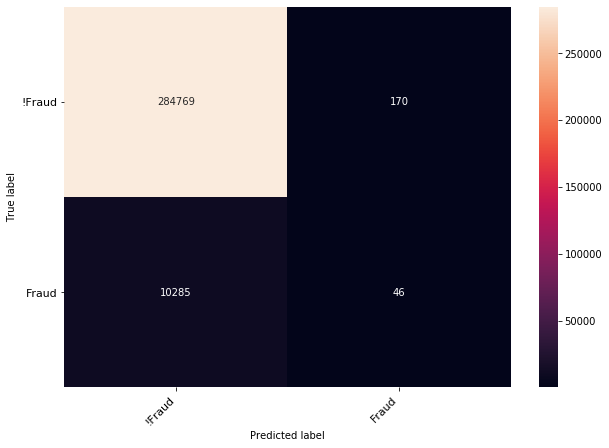

0.5019279997038588


In [8]:
# Logistic Regression on PCA
X = X_train.copy()
y = y_train.copy()

# Define the model
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    _X_train, _y_train = X.iloc[train_indices], y.iloc[train_indices]
    _X_test, _y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Normalize the data
    _X_train = normalize(_X_train)
    _X_test = normalize(_X_test)
    
    # Fit and predict!
    model.fit(_X_train, _y_train)
    _y_pred = model.predict(_X_test)
    
    # And finally: show the results
    print(classification_report(_y_test, _y_pred))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(_y_test, _y_pred)
x = print_confusion_matrix(cm, class_names=['!Fraud', 'Fraud'])
plt.show()
from sklearn.metrics import roc_auc_score
print(roc_auc_score(_y_test, _y_pred))

# Try 3: RandomForestClassifier on PCA

In [9]:
from sklearn.ensemble import RandomForestClassifier

X = X_train.copy()
y = y_train.copy()

# Define the model
model = RandomForestClassifier(n_estimators = 100, n_jobs = 1, 
                             random_state = 2016,
                             class_weight='balanced',oob_score=True)

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    _X_train, _y_train = X.iloc[train_indices], y.iloc[train_indices]
    _X_test, _y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Normalize the data
    _X_train = normalize(_X_train)
    _X_test = normalize(_X_test)
    
    # Fit and predict!
    model.fit(_X_train, _y_train)
    _y_pred = model.predict(_X_test)
    
    # And finally: show the results
    print(classification_report(_y_test, _y_pred))
    
from sklearn.metrics import roc_auc_score
print(roc_auc_score(_y_test, _y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284939
           1       0.79      0.15      0.25     10331

    accuracy                           0.97    295270
   macro avg       0.88      0.57      0.62    295270
weighted avg       0.96      0.97      0.96    295270

0.5724327759862692


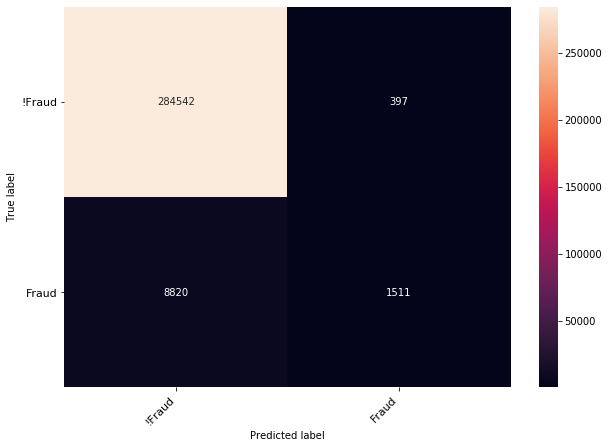

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(_y_test, _y_pred)
x = print_confusion_matrix(cm, class_names=['!Fraud', 'Fraud'])
plt.show()

# Try 4: Deal with imbalanced dataset

### SMOTE

Using TensorFlow backend.


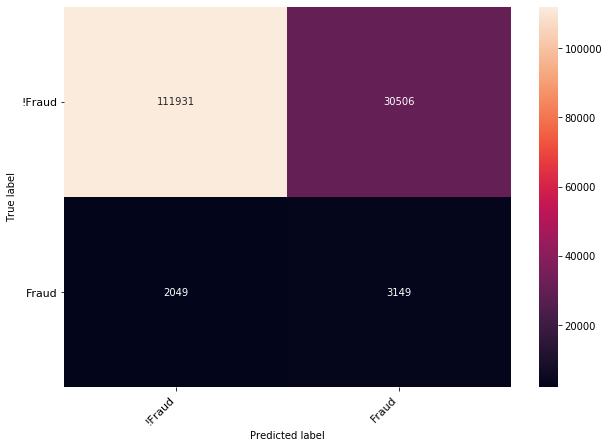

In [11]:
# Trying code from https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data
# to check any improvements.

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate input features and target
y = y_train.copy()
X = X_train.copy()

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
smote = LogisticRegression().fit(X_train, y_train)

smote_pred = smote.predict(X_test)
cm = confusion_matrix(y_test, smote_pred)
x = print_confusion_matrix(cm, class_names=['!Fraud', 'Fraud'])
plt.show()

In [13]:
# Checking accuracy
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, smote_pred)

0.6958190236986787

### ADASYN

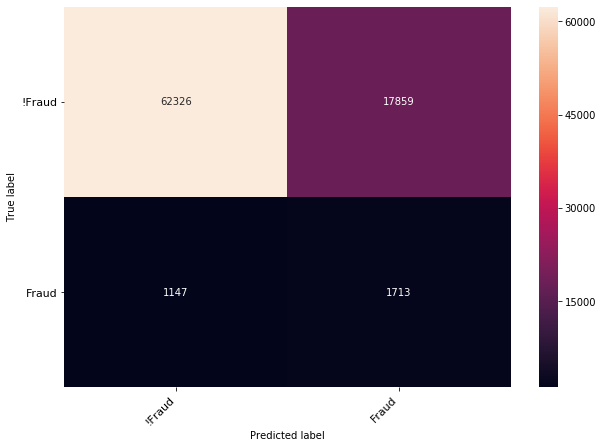

In [16]:
from imblearn.over_sampling import ADASYN

y = y_train.copy()
X = X_train.copy()

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

ada = ADASYN(random_state=42)
X_train, y_train = ada.fit_sample(X_train, y_train)
model = LogisticRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
x = print_confusion_matrix(cm, class_names=['!Fraud', 'Fraud'])
plt.show()

In [17]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.6881142973133371

### SVMSMOTE

In [ ]:
from imblearn.over_sampling import SVMSMOTE

y = y_train.copy()
X = X_train.copy()

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

svmsmote = SVMSMOTE(random_state=42)
X_train, y_train = svmsmote.fit_sample(X_train, y_train)
model = LogisticRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
x = print_confusion_matrix(cm, class_names=['!Fraud', 'Fraud'])
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)